In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#Import the libraries
from sklearn.model_selection import train_test_split    # Splits arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold               # Cross-validator
from sklearn.model_selection import cross_validate      # Evaluate metrics by cross-validation
from sklearn.model_selection import GridSearchCV        # Search over specified parameter values for an estimator
from sklearn.compose import ColumnTransformer           # Applies transformers to columns of DataFrames
from sklearn.pipeline import Pipeline                   # Helps building a chain of transforms and estimators
from sklearn.impute import SimpleImputer                # Imputation transformer for completing missing values
from sklearn.preprocessing import OneHotEncoder         # Encode categorical features

# Import the csv files

In [3]:
df_train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", index_col='id')
df_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv", index_col='id')

The dataset provided has been split into train and test datasets. 
The train dataset has 7613 rows and 4 columns. The target column is part of the train dataset.
The test dataset has 3263 rows and 3 columns. the target column is not part of the test dataset, and needs to be predicted and submitted as part of the competition.

In [4]:
print("size of train dataset",df_train.shape)
print("size of test dataset",df_test.shape)

size of train dataset (7613, 4)
size of test dataset (3263, 3)


# Test train split

Our model is to be developed on the provided train dataset. So we further split train dataset into train and validation datasets to create and validate different models.

### Split the train dataset into predictor and response variables

In [5]:
X = df_train.iloc[:,:-1] #the predictor columns are all columns except the target column
y = df_train.iloc[:,-1:] #the target column is the last column 

In [6]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                                train_size=0.8, 
                                                                test_size=0.2, 
                                                                random_state=0)

In [7]:
print("size of X_train: predictors",X_train_full.shape)
print("size of X_valid: predictors",X_valid_full.shape)
print("size of y_train: response",y_train.shape)
print("size of y_valid: response",y_valid.shape)

size of X_train: predictors (6090, 3)
size of X_valid: predictors (1523, 3)
size of y_train: response (6090, 1)
size of y_valid: response (1523, 1)


# EDA

Exploratory analysis on our new training dataset

In [8]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 1999 to 3924
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   6044 non-null   object
 1   location  4075 non-null   object
 2   text      6090 non-null   object
dtypes: object(3)
memory usage: 190.3+ KB


We see that location and keywords have some nulls.

## check the balance of the dataset

In [9]:
y_train.groupby(['target']).size()

target
0    3456
1    2634
dtype: int64

So we see that its a well balanced dataset.

## check examples of disaster and non disaster tweets

In [10]:
df_train[df_train['target']==0].head(10)

,keyword,location,text,target
id,,,,
23,NaN,NaN,What's up man?,0
24,NaN,NaN,I love fruits,0
25,NaN,NaN,Summer is lovely,0
26,NaN,NaN,My car is so fast,0
28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
31,NaN,NaN,this is ridiculous....,0
32,NaN,NaN,London is cool ;),0
33,NaN,NaN,Love skiing,0
34,NaN,NaN,What a wonderful day!,0


In [11]:
df_train[df_train['target']==1].head(10)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
14,NaN,NaN,There's an emergency evacuation happening now ...,1


# Lets try LSTM model to make predictions

For a person reading the tweets, its quite easy to understand which is a disaster and which one is not.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

We train our model on only the text column.

In [13]:
training_sentences = X_train_full['text']
validation_sentences = X_valid_full['text']
training_labels = y_train
validation_labels = y_valid

In [14]:
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

In [15]:
tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences)

tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
tokenizer.fit_on_texts(validation_sentences)

In [16]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
pad_training = pad_sequences(training_sequences, maxlen=25, padding='post', truncating='post')

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
pad_validation = pad_sequences(validation_sequences, maxlen=25, padding='post', truncating='post')

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(100000, 16, input_length=20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2022-04-03 22:37:59.896192: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(pad_training, training_labels_final, epochs=15, validation_data=(pad_validation, validation_labels_final))

2022-04-03 22:38:01.276130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
191/191 [==============================] - 26s 94ms/step - loss: 0.5484 - accuracy: 0.7144 - val_loss: 0.4626 - val_accuracy: 0.8056
Epoch 2/15
191/191 [==============================] - 17s 86ms/step - loss: 0.3796 - accuracy: 0.8394 - val_loss: 0.4416 - val_accuracy: 0.8024
Epoch 3/15
191/191 [==============================] - 16s 82ms/step - loss: 0.3128 - accuracy: 0.8755 - val_loss: 0.4904 - val_accuracy: 0.7866
Epoch 4/15
191/191 [==============================] - 17s 87ms/step - loss: 0.2711 - accuracy: 0.8954 - val_loss: 0.5630 - val_accuracy: 0.7899
Epoch 5/15
191/191 [==============================] - 16s 82ms/step - loss: 0.2371 - accuracy: 0.9103 - val_loss: 0.6115 - val_accuracy: 0.7840
Epoch 6/15
191/191 [==============================] - 16s 85ms/step - loss: 0.2010 - accuracy: 0.9287 - val_loss: 0.6522 - val_accuracy: 0.7919
Epoch 7/15
191/191 [==============================] - 17s 88ms/step - loss: 0.1694 - accuracy: 0.9394 - val_loss: 0.7417 - val_accuracy:

In [20]:
import matplotlib.pyplot as plt
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.show()

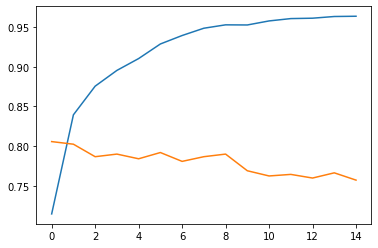

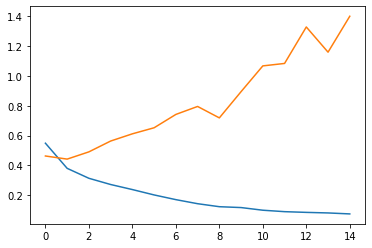

In [21]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [22]:
test_sequences = tokenizer.texts_to_sequences(df_test.text)
pad_test = pad_sequences(test_sequences,maxlen=25, padding='post', truncating='post')

In [23]:
submission=pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv", index_col='id')
prediction = model.predict(pad_test)
submission['target'] = (prediction>0.5).astype(int)

In [24]:
submission

,target
id,
0,1
2,0
3,1
9,1
11,1
...,...
10861,0
10865,1
10868,1


In [25]:
submission.to_csv('submission1_lstm.csv', index=id, header=True)